## HASPEEDE


HASPEEDE is a task about identification of hateful content online.

In [1]:
!nvidia-smi

Fri Apr 19 10:10:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [66]:
### Imports ###
import numpy as np, pandas as pd, random, re, html, json, regex, string

# Utilities
from tqdm import tqdm
from pathlib import Path
from collections import Counter, OrderedDict

# Deep learning
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import Vocab, vocab
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

# NLP libraries
import spacy
import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')

# Graphing
import matplotlib, matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.font_manager as font_manager
import seaborn as sns
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
!git clone -s https://github.com/Alessandro-vecchi/HASPEEDE.git haspeede

fatal: destination path 'haspeede' already exists and is not an empty directory.


### Loading Data

We are dealing with a binary classification problem where the goal is to identify whether a given text contains hate speech or is neutral. The dataset is structured as JSON lines, each containing a text string, possible classification choices, and a label indicating the correct class.

In [6]:
train_path = Path("haspeede/data/train-taskA.jsonl")
test_news_path = Path("haspeede/data/test-news-taskA.jsonl")
test_tweets_path = Path("haspeede/data/test-tweets-taskA.jsonl")

In [7]:
!head haspeede/data/train-taskA.jsonl -n 15 # -n NUM print the first NUM lines

{"text": "\u00c8 terrorismo anche questo, per mettere in uno stato di soggezione le persone e renderle innocue, mentre qualcuno... URL ", "choices": ["neutrale", "odio"], "label": 0}
{"text": "@user @user infatti finch\u00e9 ci hanno guadagnato con i campi #rom tutto era ok con #Alemanno #Ipocriti ", "choices": ["neutrale", "odio"], "label": 0}
{"text": "Corriere: Tangenti, Mafia Capitale dimenticataMazzette su buche e campi rom URL #roma ", "choices": ["neutrale", "odio"], "label": 0}
{"text": "@user ad uno ad uno, perch\u00e9 quando i migranti israeliti arrivarono in terra di Canaan fecero fuori tutti i Canaaniti. ", "choices": ["neutrale", "odio"], "label": 0}
{"text": "Il divertimento del giorno? Trovare i patrioti italiani che inneggiano contro i rom facendo la spesa alla #Lidl (multinazionale tedesca). ", "choices": ["neutrale", "odio"], "label": 0}
{"text": "Modena: Comune paga la benzina ai nomadi che portano figli a scuola: MODENA \u2013 La giunta PD\u2026 URL ", "choices": ["

In [8]:
def standardize_tweets(text):
    # Replace curly quotes
    text = re.sub(r"[‘’]", "'", text)
    text = re.sub(r'[`´]', '"', text)
    text = re.sub(r'[“”]', '"', text)

    # Standardize dashes
    text = re.sub(r"–", "-", text)  # Replace en-dash with hyphen-minus

    # fix accents
    text = re.sub(r"[á]", "à", text)
    text = re.sub(r'[ú]', 'u', text)
    text = re.sub(r'[ó]', 'o', text)
    return text


In [9]:
def load_jsonl_to_df(filepath):
    data = []
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
          t = json.loads(line.strip())
          t["text"] = standardize_tweets(t["text"])
          data.append(t)
    return pd.DataFrame(data)

# Load training data
train_df = load_jsonl_to_df(train_path)

## Understanding Data

Understanding data is a crucial step for several reasons:

- **Model Design**: Data insights inform algorithm selection, preprocessing, and feature engineering.
- **Accuracy Improvement**: Detailed data knowledge allows precise model tuning to improve accuracy.
- **Bias Identification**: Early data analysis detects biases, ensuring fairness and ethical model use.
- **Training Efficiency**: Proper understanding optimizes training by setting correct validation, class balancing, and managing fitting issues.




Firstly, let's see how big are the datasets we are getting. Knowing the number of entries in each dataset segment (training, testing) helps plan how to split data for training and validation, ensures there's enough data for robust testing, and sets expectations for model evaluation. It also indicates the volume of data the model will handle, which influences decisions on computational resources and training time.

### Dataset Size

- **Training and Validation Split**: Knowledge of dataset sizes helps in effectively splitting data for training and validation.
- **Robust Testing**: Ensures there is sufficient data for reliable model testing and evaluation.
- **Resource Allocation**: Informs the required computational resources and expected training durations.

In [10]:
def count_lines(path: Path) -> int:
    with open(path, "rb") as f:
        return len(f.readlines())

print(f"Total number of lines in training dataset: {count_lines(train_path)}")
print(f"Total number of lines in the test_news dataset: {count_lines(test_news_path)}")
print(f"Total number of lines in test_tweets dataset: {count_lines(test_tweets_path)}")

Total number of lines in training dataset: 6839
Total number of lines in the test_news dataset: 500
Total number of lines in test_tweets dataset: 1263



**Analysis**:
- The training set size (6,839 entries) is large enough to train a model, but it's probably better to consider validation split strategies to avoid overfitting.
- The sizes of the test datasets (500 for news and 1,263 for tweets) are adequate for testing but highlight the need for careful model evaluation to ensure generalizability across different types of content.

### Class distribution in training data

This distribution shows a relatively balanced dataset, with a slight skew towards 'neutrale' classes.

A simple baseline model could predict the majority class ('neutrale'), therefore **60%** is the minimum benchmark to surpass, ensuring that improvements are due to learning and not random chance.

**Reminders**:

The slight imbalance highlights the importance of the model performing well on the 'odio' class to avoid biases. A model overly biased towards predicting 'neutrale' could miss critical instances of 'odio', undermining its practical utility.
Techniques such as class weighting or oversampling might be employed to address the slight imbalance and increare the accuracy.

In [11]:
# Analyze class distribution
class_distribution = train_df['label'].value_counts(normalize=True).reset_index()  # normalized to show percentages

class_distribution.columns = ['Sentiment', 'Percentage']

class_distribution['Sentiment'] = ['Neutrale', 'Odio']
class_distribution

,Sentiment,Percentage
0,Neutrale,0.595555
1,Odio,0.404445


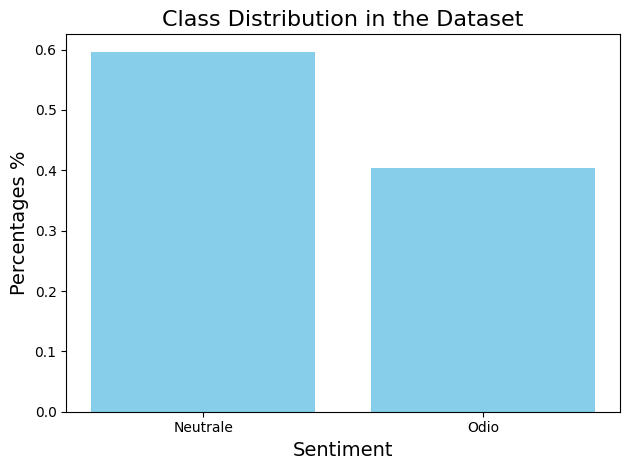

In [12]:
plt.figure()
plt.bar(class_distribution['Sentiment'], class_distribution['Percentage'], color='skyblue')
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Percentages %', fontsize=14)
plt.title('Class Distribution in the Dataset', fontsize=16)
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

### Text Length Analysis


* Inform preprocessing decisions, like padding or truncation, for neural network input.
* The analysis helps in managing varying text lengths, which can affect model training and performance.




Word count offers insights into the linguistic structure and content density while character count helps understand spacing, punctuation, and encoding complexities.

In [13]:
# Analyze text lengths
text_len = pd.DataFrame(columns = ['text_length_words', 'text_length_chars'])

text_len['text_length_words'] = train_df['text'].apply(lambda x: len(x.split()))
text_len['text_length_chars'] = train_df['text'].apply(len)

text_len

,text_length_words,text_length_chars
0,19,120
1,17,101
2,12,86
3,20,118
4,20,138
...,...,...
6834,45,285
6835,45,277
6836,36,233
6837,38,206


The average length suggests that the majority of text samples are concise, likely due to the dataset's social media origin.
The presence of outliers can skew the model's ability to learn from the more typical, shorter texts.

In [14]:
# Basic statistics for text lengths in words
average_length_words = text_len['text_length_words'].mean()
max_length_words = text_len['text_length_words'].max()  # possible outlier

print(f"Average Length in Words: {average_length_words}")
print(f"Maximum Length in Words: {max_length_words}")

Average Length in Words: 23.36949846468782
Maximum Length in Words: 94


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


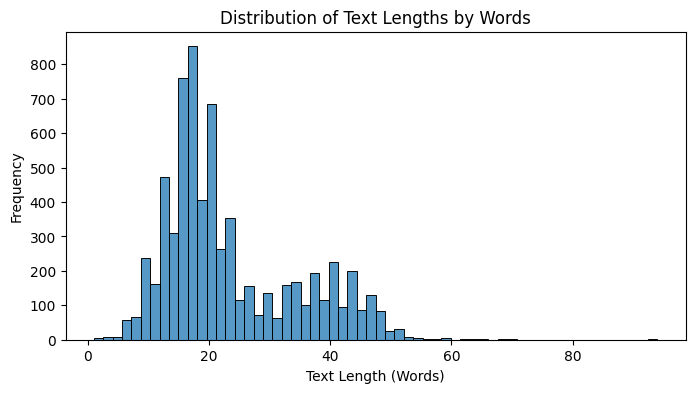

In [15]:
# Plot histogram of text lengths in words
plt.figure(figsize=(8, 4))
sns.histplot(text_len['text_length_words'], bins=60)
plt.title('Distribution of Text Lengths by Words')
plt.xlabel('Text Length (Words)')
plt.ylabel('Frequency')
plt.show()

In [16]:
# Basic statistics for text lengths in characters
average_length_chars = text_len['text_length_chars'].mean()
max_length_chars = text_len['text_length_chars'].max()
print(f"Average Length in Characters: {average_length_chars}")
print(f"Maximum Length in Characters: {max_length_chars}")

Average Length in Characters: 148.38265828337475
Maximum Length in Characters: 581


Both distributions are right-skewed, indicating that most texts are short, with a few much longer samples.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


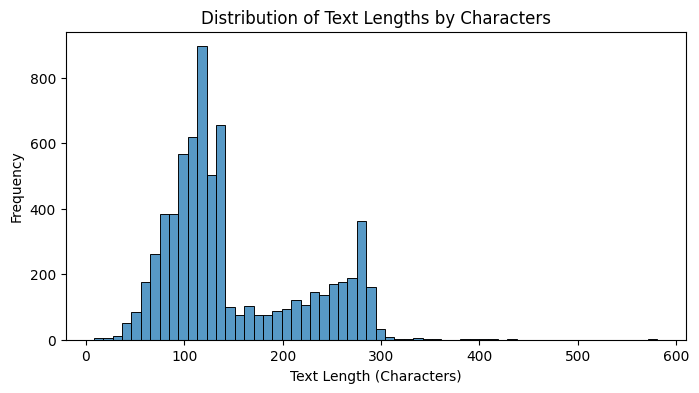

In [17]:
# Plot histogram of text lengths in characters
plt.figure(figsize=(8, 4))
sns.histplot(text_len['text_length_chars'], bins=60)
plt.title('Distribution of Text Lengths by Characters')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Frequency')
plt.show()

The peaks indicate the most common text lengths, providing a target range for standardizing input sizes.

**Reminders** to improve quality:
- *Truncation*: cutting off texts longer than a set threshold to reduce the impact of outliers.
- *Padding*: shorter texts can be padded to ensure uniform input length for the model.
- *Outlier Analysis*: reviewing outlier content could inform whether these samples are anomalies or contain valuable information.

vedere se outlier sono neutrali o hateful

### Vocabulary analysis



The frequency of words like '@user' and 'URL' suggests common placeholders that might need to be removed or replaced because they likely do not contribute to understanding the sentiment or class of the text. The prevalence of common Italian stopwords and prepositions ('e', 'di', 'che', ...) suggests that removing or retaining stopwords could be an important preprocessing step to focus the model on more meaningful words.

In [18]:
all_words = [word.lower() for text in train_df['text'] for word in text.split()]
word_counts = Counter(all_words)
vocabulary_size = len(word_counts)
most_common_words = word_counts.most_common(20)

print(f"Vocabulary Size: {vocabulary_size}")
print("Most Common Words:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")

Vocabulary Size: 30269
Most Common Words:
@user: 4663
e: 4106
di: 4086
url: 3504
che: 2945
i: 2889
a: 2773
in: 2264
il: 2241
la: 2210
non: 2036
per: 1870
è: 1457
un: 1297
gli: 1201
sono: 1182
le: 1038
rom: 1004
con: 990
da: 981


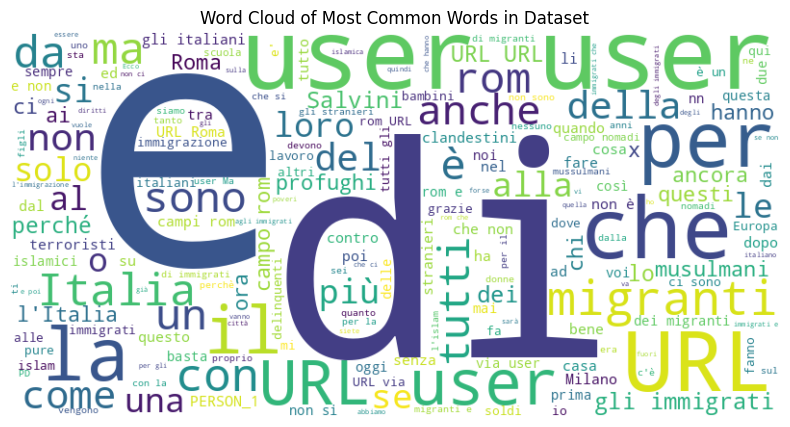

In [19]:
# Collect all text data into one large string
text = ' '.join(train_df['text'])

# Create a word cloud object
wordcloud = WordCloud(width = 800, height = 400, background_color ='white',
                          max_words=200, contour_width=3, contour_color='steelblue').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title('Word Cloud of Most Common Words in Dataset')
plt.show()

It's fundamental to analyze also strange characters, in order to understand if they should be kept, discarded or replaced.

The result is extremely valuable. Of course, speaking of italian language, accented characters are extremely important and can alter the meaning of words if removed. Certain punctuation characters are can be significant for understanding the structure of sentences and, by extension, the sentiment or emphasis in the text (e.g., exclamation marks may indicate strong emotion). Curly quotes and dashed should be stamdardized (e.g., “,”,’,`, all to ').
Emojis are increasingly used to express emotions and can be quite informative for sentiment analysis and hate speech detection. For example, 😡 may indicate anger or frustration, which is relevant in the context of hate speech. Thus, they will be converted to a textual representation that captures their sentiment (like :angry:).

Other punctuation marks like angle brackets (< >) or pipes (|), currency symbols (€), percentages (%) could be removed since they do not contribute to the task.

Twitter handles '@' and hashtags '#', and characters like �, which typically represent encoding errors, should be investigated further.

In [20]:
# Regular expression pattern to match common characters:
# This includes ASCII letters, digits, common punctuation, and whitespace.
# You can adjust it to include any additional characters you consider 'normal'.

# Function to find strange characters
def find_strange_characters(text):
    normal = "a-zA-Z0-9"
    accented_letters = "àèéìòùÀÈÉÒÙ"
    punctuation = re.escape('\\') + ",.!?;:<>#/'\"…-"
    normal_chars_pattern = f"[\s{normal}{accented_letters}{punctuation}]+"
    # Find all characters that are NOT in the normal pattern
    strange_chars = re.sub(normal_chars_pattern, '', text)
    return strange_chars

# Apply the function to each text entry and collect the strange characters
all_strange_characters = ''.join(train_df['text'].apply(find_strange_characters))

# Count the occurrences of each strange character
strange_char_counter = Counter(all_strange_characters)

# Sort and print the most common strange characters
print(f"Number of strange characters: {len(strange_char_counter.keys())}")
for char, count in strange_char_counter.most_common():
    print(f"Character: {char} | Occurrences: {count}")


Number of strange characters: 203
Character: @ | Occurrences: 4727
Character: ) | Occurrences: 412
Character: ( | Occurrences: 396
Character: _ | Occurrences: 211
Character: � | Occurrences: 173
Character: « | Occurrences: 112
Character: » | Occurrences: 106
Character: % | Occurrences: 91
Character: + | Occurrences: 85
Character: 😡 | Occurrences: 70
Character: | | Occurrences: 68
Character: 😂 | Occurrences: 57
Character: € | Occurrences: 47
Character: ️ | Occurrences: 42
Character: * | Occurrences: 37
Character: 🇮 | Occurrences: 37
Character: 🇹 | Occurrences: 36
Character: & | Occurrences: 36
Character: 👎 | Occurrences: 32
Character: • | Occurrences: 29
Character: 🤣 | Occurrences: 27
Character: 😁 | Occurrences: 25
Character: 🤔 | Occurrences: 23
Character: 💩 | Occurrences: 23
Character: = | Occurrences: 19
Character: ] | Occurrences: 18
Character: [ | Occurrences: 17
Character: 👍 | Occurrences: 16
Character: 😠 | Occurrences: 14
Character: 👿 | Occurrences: 14
Character: 👏 | Occurrences: 

In [21]:
least_frequents = ''
for char, count in strange_char_counter.most_common()[::-1]:
    # print(f"Character: {char} | Occurrences: {count}")
    if count>8:
      break
    least_frequents += char

least_frequents

'😪🐜⬇🎄😯🔫🙏👕„📖🌏☹⭐🤐🏐⛅🐓🐖🍺🍷✝☪⌨🦅👊😩！📌✍ℹ🇫👈🔽📺📢📆✂🌹🚫💔😫👋😟🤚Å↪🤪🍸💬😥🖒ĺ🕋🤡🕌💣â\x94\x93👹ë👌مالس🇧🇬🤓аоІ🏼ā🙂🏾×💚⚡🤫♂👀▪🖊➡🇷ø✋😘😐✊🌈⁉🤨🌍😜📍~🌿ʼ💖😅►🔥ė—❤♻✳і😲😆💃Ì😬🏿\u200b^😒💥⛔😊😉🤕í▶е☺😑🇾🇸🐒😔🤬🆘❌😎😷😀🙈❓✌👉🌟❗‼👇$🧐🤢😨🏻🇺😢✔😣🔴😱😈🔹🇪'

In [22]:
def remove_characters(text):
    # Remove @user.
    # text = re.sub(r'@user', '', text)
    # Since there are some non-renamed users, (i. e. @M_decimoMeridio, @OllaPiero, @ibico75, @Noiconsalvini:, @indivanados:, @rossbova])
    # Remove usernames: any string that starts with @ and continues until a space or punctuation
    text = re.sub(r'@\w+\b', '', text)

    # Remove URLs, case-insensitive
    text = re.sub(r'url', '', text, flags=re.IGNORECASE)

    # Remove non-frequent characters
    text = re.sub(f'[{re.escape(least_frequents)}]', '', text)

    # Remove variation selectors and other non-visible characters, like U+FE0F Variation Selector-16 and Zero Width Joiner
    text = regex.sub(r'[\u200D\uFE0F]', '', text)

    # Remove useless punctuation
    text = re.sub(r'[()\[\]«»|�*&_•°]+', '', text)

    return text

In [23]:
train_df['text'] = train_df['text'].apply(lambda x: remove_characters(x))

In [24]:
def remove_c(text):
    text = re.sub(r'[()\[\]+«»|�*&%€_=•]+', '', text) #17

    text = re.sub(r'[😂️🙄👍😡🤔👎👏👿💩🤮️😁😠😤🤦🤣😭]+', '', text) #17
    return text

m  = remove_c(all_strange_characters)

In [25]:
all_strange_characters = ''.join(train_df['text'].apply(find_strange_characters))

strange_char_counter = Counter(all_strange_characters)

print(f"Number of strange characters: {len(strange_char_counter.keys())}")
chars = []
for char, count in strange_char_counter.most_common():
    print(f"Character: {char}, {ord(char)} | Occurrences: {count}")
    chars.append(char)

Number of strange characters: 26
Character: %, 37 | Occurrences: 91
Character: +, 43 | Occurrences: 85
Character: 😡, 128545 | Occurrences: 70
Character: 😂, 128514 | Occurrences: 57
Character: €, 8364 | Occurrences: 47
Character: 🇮, 127470 | Occurrences: 37
Character: 🇹, 127481 | Occurrences: 36
Character: 👎, 128078 | Occurrences: 32
Character: 🤣, 129315 | Occurrences: 27
Character: 😁, 128513 | Occurrences: 25
Character: 🤔, 129300 | Occurrences: 23
Character: 💩, 128169 | Occurrences: 23
Character: =, 61 | Occurrences: 19
Character: 👍, 128077 | Occurrences: 16
Character: 😠, 128544 | Occurrences: 14
Character: 👿, 128127 | Occurrences: 14
Character: 👏, 128079 | Occurrences: 13
Character: 🤮, 129326 | Occurrences: 13
Character: 😭, 128557 | Occurrences: 13
Character: 🙄, 128580 | Occurrences: 11
Character: 😤, 128548 | Occurrences: 11
Character: 🤦, 129318 | Occurrences: 11
Character: 🖕, 128405 | Occurrences: 10
Character: 😳, 128563 | Occurrences: 9
Character: 😄, 128516 | Occurrences: 9
Characte

In [26]:
def find_texts_with_character(df, character):
    # Filter the DataFrame for texts containing the specific character
    contains_char_df = df[df['text'].str.contains(character, regex=False)]
    return contains_char_df['text'].tolist()

# Assuming 'train_df' is your DataFrame and it has a column 'text' that contains the text entries
texts_with_char = find_texts_with_character(train_df, r'€') # … <PERSON_1>

# This will print out all texts that contain the character '�'
for text in texts_with_char:
    print(text)


  e aggiungo, xké  nn lo ha fatto x clandestini rom iussoli stranieri criminali UE e € ? Parole parole 
SCHIAFFO ALLA MISERIA Regali da 30.000€ per il battesimo del bimbo rom. E poi in Italia ci sono famiglie sinti...  
#RISORSE ormai insediate: "Sequestrati 30 MILIONI € a famiglie #rom di #Cerveteri". Hanno tutti la cittadinanza nel #PrincipatoDiBoldrinia. 
22 rapine in tutto il nord, bottino da 1 milione €. Presa la banda di rumeni rom?. Saran presto liberi??  
 60 milioni di € per allestire campi rom nel 2009 --- siete stati voi della Lega .... #LaRuspetta? 
A mio parere l'unica cosa da fare era utilizzare i € 150.000,00 per lo smantellamento del campo nomadi. Campo tra...  
Famiglia di posteggiatori abusivi rom incassa 2.400€ al mese: "Tanto non ci potete fare nulla"  via  
35 €/die ad un immigrato per stare seduto a non fare un cazzo o 600€/die a #Salvini per stare seduto e dire cazzate? #maleminore #dilemma 
 Il "pubico" di Renzi sono topi voltagabbana rom islamici ebrei Confinba

In [27]:
def calculate_char_frequencies(df, strange_characters):
    # Initialize a dictionary to hold frequencies
    char_frequencies = {char: {'neutrale': 0, 'odio': 0} for char in strange_characters}

    # Count occurrences of each character in each class
    for char in strange_characters:
        for index, row in df.iterrows():
            if char in row['text']:
                label = 'neutrale' if row['label'] == 0 else 'odio'
                char_frequencies[char][label] += 1

    # Normalize by the number of sentences in each class
    total_neutrale = len(df[df['label'] == 0])
    total_odio = len(df[df['label'] == 1])
    for char in char_frequencies:
        char_frequencies[char]['neutrale'] /= total_neutrale
        char_frequencies[char]['odio'] /= total_odio

    return char_frequencies

# Calculate frequencies
frequencies = calculate_char_frequencies(train_df, chars)
frequencies

{'%': {'neutrale': 0.011293886570095753, 'odio': 0.012653651482284888},
 '+': {'neutrale': 0.005155904738521974, 'odio': 0.008315256688358641},
 '😡': {'neutrale': 0.001718634912840658, 'odio': 0.007592190889370932},
 '😂': {'neutrale': 0.0027007120058924624, 'odio': 0.004699927693420101},
 '€': {'neutrale': 0.00441934691873312, 'odio': 0.007592190889370932},
 '🇮': {'neutrale': 0.0027007120058924624, 'odio': 0.005061460592913955},
 '🇹': {'neutrale': 0.0024551927326295114, 'odio': 0.005061460592913955},
 '👎': {'neutrale': 0.0012275963663147557, 'odio': 0.0025307302964569776},
 '🤣': {'neutrale': 0.0012275963663147557, 'odio': 0.0021691973969631237},
 '😁': {'neutrale': 0.0012275963663147557, 'odio': 0.0025307302964569776},
 '🤔': {'neutrale': 0.0027007120058924624, 'odio': 0.0032537960954446853},
 '💩': {'neutrale': 0.00024551927326295114, 'odio': 0.0039768618944323935},
 '=': {'neutrale': 0.0024551927326295114, 'odio': 0.0025307302964569776},
 '👍': {'neutrale': 0.0009820770930518046, 'odio':

In [28]:
len(frequencies)

26

In [29]:
def plot_freq_strange_char(start=0, end=10, xlabels=None):

    f = dict(list(frequencies.items())[start:end])
    freq_df = pd.DataFrame(f).transpose()

    # Plotting the bar chart using the specified font
    ax = freq_df.plot(kind='bar', figsize=(15, 5), legend=True)
    plt.title('Frequency of Strange Characters by Class')
    plt.xlabel('Characters')
    plt.ylabel('Normalized Frequency')

    # Set custom x-labels if provided
    if xlabels:
        ax.set_xticklabels(xlabels, rotation=90)  # Rotate labels if needed

    plt.show()

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127470 (\N{REGIONAL INDICATOR SYMBOL LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127481 (\N{REGIONAL INDICATOR SYMBOL LETTER T}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128078 (\N{THUMBS DOWN SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129300 (\N{THINKING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt

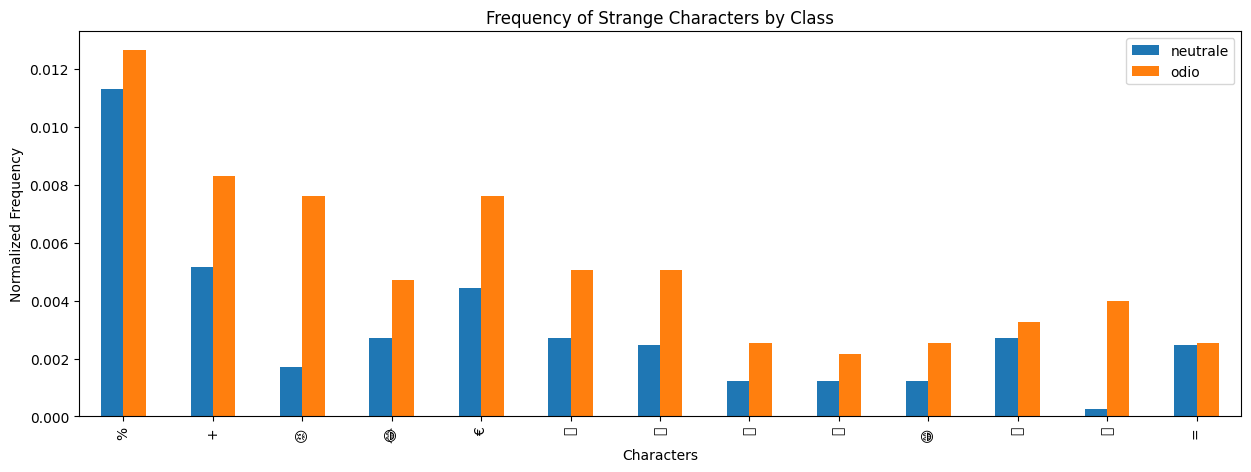

In [30]:
xlabels = ["%", "+", "😡", "😂️", "€", "🇮", "🇹", "👎", "🤣", "😁", "🤔", "💩", "="]
plot_freq_strange_char(0, 13, xlabels)

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128127 (\N{IMP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128079 (\N{CLAPPING HANDS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129326 (\N{FACE WITH OPEN MOUTH VOMITING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPy

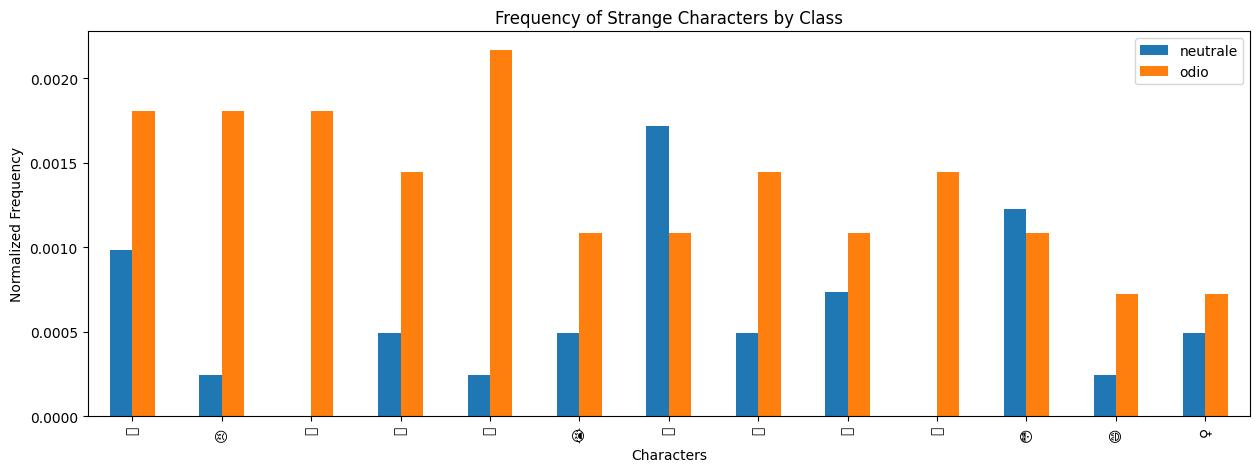

In [31]:
xlabels = ["👍", "😠", "👿", "👏", "🤮️", "😭", "🙄", "😤", "🤦", "🖕", "😳"]
plot_freq_strange_char(13, 26)

In [32]:
!pip install emoji

In [33]:
import emoji

def convert_emojis_to_text(text):
    return emoji.demojize(text, delimiters=("", ""), language='it')

train_df['text'] = train_df['text'].apply(lambda x: convert_emojis_to_text(x))

In [34]:
!pip install stopwordsiso

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 781.3 kB/s eta 0:00:0000:0100:01


In [38]:
!python3 -m spacy download it_core_news_sm > /dev/null

In [36]:
!python3 -m spacy download it_core_news_md > /dev/null

In [39]:
import stopwordsiso as stopwords

# Load the Italian language model
spacy.prefer_gpu()
nlp = spacy.load("it_core_news_sm", enable = ["tokenizer"]) #exclude=['parser', 'ner', 'lemmatizer', 'tagger', 'morphologizer', 'senter'])

# Define your list of additional stopwords
additional_stopwords = set()
# additional_stopwords.update({'alcun', 'alcuna', 'alcune', 'alcuno', 'almeno', 'altra','anche', 'bel','bella','beh','boh', 'buon', 'buona',"c'è",'capito','ce','ciao','complimenti', 'cmq','credo','davvero','direi',"e'",'é','giusto','lì', 'messo','neanche', 'nn','ok','ovviamente','penso', 'piace',  "po'",'pò','posso','puoi','sa', 'si', 'sì', 'sicuramente','sicuro','so','spero','tanti','tipo', 'veramente','vero', 'volevo','voglio', 'vorrei', 'vorrebbe', 'vuole', 'xk', 'xkè'})
additional_stopwords.update({'piacere', 'salve', 'buongiorno', 'benvenuto', 'benvenuta', 'buonasera', 'buonanotte', 'bentornato', 'bentornata'})
# additional_stopwords.update({'vedere', 'potere', 'dovere', 'venire', 'volere', 'andare', 'fare', 'dare'})
# Get the default Italian stopwords from spaCy
italian_stopwords = spacy.lang.it.stop_words.STOP_WORDS
italian_stopwords.update(set(nltk_stopwords.words('italian')))
#italian_stopwords.update(set(stopwords.stopwords("it")))

italian_stopwords.update(additional_stopwords)

print(len(italian_stopwords))

637


In [40]:
# Assuming `italian_stopwords` and `nlp` are already defined
def tokenize_italian_nostop(text):
    doc = nlp(text.strip())
    tokens = []
    for token in doc:
        if token.text not in italian_stopwords:
            if token.text in string.punctuation and tokens and tokens[-1] not in string.punctuation:
                tokens.append(token.text)
            else:
              tokens.append(token.text)

    if tokens[0] in string.punctuation:
      del tokens[0]
    tokens[0] = tokens[0].title()
    return tokens

# Apply the tokenizer to each entry in the DataFrame
train_df['tokens_nostopwords'] = train_df['text'].apply(tokenize_italian_nostop)


In [41]:
# Function to tokenize text
def tokenize_italian(text):
    text = text.strip()
    text = text[0].title()+text[1:]
    # Process the text with the NLP model
    doc = nlp(text)
    # Extract tokens from the doc
    tokens = [token.text for token in doc]
    return tokens

# Apply the tokenizer to each entry in the DataFrame
train_df['tokens'] = train_df['text'].apply(tokenize_italian)


In [42]:
train_df.tail(5)

,text,choices,label,tokens_nostopwords,tokens
6834,Gli stati nazionali devono essere pronti a rin...,"[neutrale, odio]",0,"[Gli, nazionali, devono, pronti, rinunciare, p...","[Gli, stati, nazionali, devono, essere, pronti..."
6835,Il ministro dell'interno della Germania #Horst...,"[neutrale, odio]",0,"[Il, interno, Germania, #, HorstSeehofer, ,, p...","[Il, ministro, dell', interno, della, Germania..."
6836,#Salvini: In Italia troppi si sono montati la ...,"[neutrale, odio]",0,"[Salvini, :, In, Italia, troppi, montati, test...","[#, Salvini, :, In, Italia, troppi, si, sono, ..."
6837,Chi giubila in buona fede non ha capito nien...,"[neutrale, odio]",0,"[Chi, giubila, buona, fede, capito, ., Purtrop...","[Chi, giubila, in, buona, fede, non, ha, capit..."
6838,I giovani cristiani in #Etiopia sono indotti d...,"[neutrale, odio]",0,"[I, giovani, cristiani, #, Etiopia, indotti, i...","[I, giovani, cristiani, in, #, Etiopia, sono, ..."


### Full pre-processing pipeline

In [43]:
class TextPreprocessor:
    def __init__(self, path):
        self.path = path
        spacy.prefer_gpu()
        self.nlp = spacy.load("it_core_news_md", enable = ["tokenizer"]) #exclude=['parser', 'ner', 'lemmatizer', 'tagger', 'morphologizer', 'senter'])
        self.italian_stopwords = self.load_stopwords()
        self.least_frequents = None

    def load_stopwords(self):
        italian_stopwords = spacy.lang.it.stop_words.STOP_WORDS
        italian_stopwords.update(set(nltk_stopwords.words('italian')))
        italian_stopwords.update(set(stopwords.stopwords("it")))
        additional_stopwords = {'piacere', 'salve', 'buongiorno', 'benvenuto', 'benvenuta', 'buonasera', 'buonanotte', 'bentornato', 'bentornata'}
        italian_stopwords.update(additional_stopwords)
        return italian_stopwords

    def load_jsonl_to_df(self):
        data = []
        with open(self.path, 'r', encoding='utf-8') as file:
            for line in file:
                t = json.loads(line.strip())
                t["text"] = self.standardize_tweets(t["text"])
                data.append(t)
        return pd.DataFrame(data)

    def standardize_tweets(self, text):
        text = re.sub(r"[‘’]", "'", text)
        text = re.sub(r'[`´]', '"', text)
        text = re.sub(r'[“”]', '"', text)
        text = re.sub(r"–", "-", text)
        text = re.sub(r"[á]", "à", text)
        text = re.sub(r'[ú]', 'u', text)
        text = re.sub(r'[ó]', 'o', text)
        return text

    def preprocess_texts(self, df):
        self.least_frequents = self.get_least_frequents(df)
        df['text'] = df['text'].apply(self.remove_characters)
        df['text'] = df['text'].apply(lambda x: emoji.demojize(x, delimiters=("", ""), language='it'))
        df['text'] = re.sub(r'[_]+', '', text)
        df['tokens_nostopwords'] = df['text'].apply(self.tokenize_italian_nostop)
        df['tokens'] = df['text'].apply(self.tokenize_italian)
        return df

    def remove_characters(self, text):
      # removing @user and url
        text = re.sub(r'@\w+\b', '', text)
        text = re.sub(r'url', '', text, flags=re.IGNORECASE)

        # removing non-frequent strange chars and non-meaningful symbols
        text = re.sub(f'[{re.escape(self.least_frequents)}]', '', text)
        
        # Remove variation selectors and other non-visible characters, like U+FE0F Variation Selector-16 and Zero Width Joiner
        text = regex.sub(r'[\u200D\uFE0F]', '', text)

        # Remove useless punctuation
        text = re.sub(r'[()\[\]«»|�*&_•°]+', '', text)
        return text

    def get_least_frequents(self, df):

      # Apply the function to each text entry and collect the strange characters
      all_strange_characters = ''.join(df['text'].apply(self.find_strange_characters))

      # Count the occurrences of each strange character
      strange_char_counter = Counter(all_strange_characters)

      least_frequents = ''
      for char, count in strange_char_counter.most_common()[::-1]:
          if count>8:
            break
          least_frequents += char
      return least_frequents

    def find_strange_characters(self, text):
        normal = "a-zA-Z0-9"
        accented_letters = "àèéìòùÀÈÉÒÙ"
        punctuation = re.escape('\\') + ",.!?;:<>#/'\"…-"
        normal_chars_pattern = f"[\s{normal}{accented_letters}{punctuation}]+"
        strange_chars = re.sub(normal_chars_pattern, '', text)
        return strange_chars

    def tokenize_italian_nostop(self, text):
        doc = self.nlp(text.strip())
        tokens = [token.text for token in doc if token.text not in self.italian_stopwords and token.text not in string.punctuation]
        if tokens[0] in string.punctuation:
          del tokens[0]
        tokens[0] = tokens[0].title()
        return tokens

    def tokenize_italian(self, text):
        text = text.strip()
        text = text[0].title()+text[1:]
        doc = self.nlp(text)
        tokens = [token.text for token in doc]
        if tokens:
            tokens[0] = tokens[0].title()
        return tokens

We also need to create a vocab map for words in our dataset, which will map tokens to numbers. This will be useful later, since torch PyTorch use tensors of sequences of numbers as inputs.

In [67]:
class HASPEEDE(Dataset):

    def __init__(
        self,
        df: pd.DataFrame,
        max_length: int = 1028,
        device: str = "cpu"
    ):
        self.tokenizer = "tokens"
        # Save samples from input file
        self.samples = df

        # Initialize indexed data attribute but leave it None
        # Must be filled through the `.index(vocabulary, label_vocabulary)` method
        self.indexed_data: list[dict] | None = None

        # Keep track of the maximum length to allow for a batch
        self.max_length = max_length

        # Save device
        self.device = torch.device(device)

        # Keep track of padding id
        self.padding_id: int | None = None

    def get_raw_element(self, idx: int) -> dict:
        return self.samples.iloc[idx].to_dict()

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> dict:
        if self.indexed_data is None:
            raise RuntimeError(
                "Trying to retrieve samples but dataset has not been indexed yet!"
                + " Be sure to call `.index()` on this object."
                + " If you want to retrieve raw elements, call `.get_raw_elements(idx)"
            )
        return self.indexed_data[idx]

    """
    This method takes a dataframe and builds a vocabulary to unique number map.

    """
    def get_vocabulary(
        self,
        pad_token: str = "<pad>",
        unk_token: str = "<unk>",
        extra_tokens: list[str] = []
    ) -> Vocab:

        # mapping each token to its frequency
        vocab_counter = Counter(token for sent in self.samples[self.tokenizer] for token in sent)

        # most_common() returns a list of (token, count) pairs, so we convert them back into dictionary
        # conversion back is about using the ordered nature of the list for any subsequent operations
        # that might rely on the frequency of tokens (e.g., trimming the vocabulary to a fixed size based on token frequency, where order matters).
        vocab_counter = OrderedDict(vocab_counter.most_common())
        # vocab class creates an indexed vocabulary where each unique token is assigned a specific index.
        vocabulary = vocab(vocab_counter, min_freq=1, specials=[pad_token, unk_token, *extra_tokens])
        # vocabulary(list of tokens) returns a list of values, so get the only one
        vocabulary.set_default_index(vocabulary([unk_token])[0])

        return vocabulary

    def set_padding_id(self, value: int) -> None:
        self.padding_id = value

    def index(self, vocabulary: Vocab) -> None:
        if self.indexed_data is not None:
            print("Dataset has already been indexed. Keeping old index...")
            return

        self.indexed_data = [{"input_ids": [vocabulary[token] for token in sample[self.tokenizer]],
                              "label": sample["label"]}
                             for _, sample in self.samples.iterrows()]

    def _collate_fn(self, raw_batch: list[dict]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        if self.padding_id is None:
            raise RuntimeError("Padding value not set! Set it through .set_padding_id method.")

        # We need these sequence lengths to construct a `torch.nn.utils.rnn.PackedSequence` in the model
        sequence_lengths = torch.tensor([len(sample["input_ids"]) for sample in raw_batch], dtype=torch.long)

        # adding vocabulary['<pad>] as padding to all sentences. Size [batch, max_len, *]
        padded_sequence = pad_sequence(
            (
                torch.tensor(sample["input_ids"], dtype=torch.long, device=self.device)
                for sample in raw_batch
            ),
            batch_first=True,
            padding_value=self.padding_id
        )
        labels = torch.tensor([sample["label"] for sample in raw_batch], device=self.device, dtype=torch.long)
        return sequence_lengths, padded_sequence, labels

#### Part 1.3 Split the training dataset into training and validation

In [45]:
# split_train_val
# This method takes a dataframe and splits it into train/val splits.
# It uses the props argument to split the dataset appropriately.
#
# args:
# df - the entire dataset DataFrame
# props - proportions for each split in the order of [train, validation].
#
# returns:
# train DataFrame, val DataFrame
#
def split_train_val(df: pd.DataFrame, props=[.8, .2]) -> tuple[pd.DataFrame, pd.DataFrame]:
    assert round(sum(props), 2) == 1 and len(props) == 2
    train_df, val_df = None, None

    size1 = int(props[0]*len(df))
    train_df = df.iloc[: size1]
    val_df = df.iloc[size1:]

    return train_df, val_df

In [68]:
pad_token, unk_token = "<pad>", "<unk>"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Getting the data path
train_path = Path("haspeede/data/train-taskA.jsonl")
test_news_path = Path("haspeede/data/test-news-taskA.jsonl")
test_tweets_path = Path("haspeede/data/test-tweets-taskA.jsonl")

# Computing training pre-processor
preprocessor = TextPreprocessor(train_path)
train_dataset_data = preprocessor.load_jsonl_to_df()
train_dataset_preprocessed = preprocessor.preprocess_texts(train_dataset_data)

# Splitting training in train and val
train_dataset_preprocessed, val_dataset_preprocessed = split_train_val(train_dataset_preprocessed)

# Computing tests pre-processor
t_n_preprocessor = TextPreprocessor(test_news_path)
test_news_data = t_n_preprocessor.load_jsonl_to_df()
test_news_preprocessed = t_n_preprocessor.preprocess_texts(test_news_data)

t_t_preprocessor = TextPreprocessor(test_tweets_path)
test_tweets_data = t_t_preprocessor.load_jsonl_to_df()
test_tweets_preprocessed = t_t_preprocessor.preprocess_texts(test_tweets_data)

# Making datasets torch oriented
train_dataset = HASPEEDE(train_dataset_preprocessed, device=device)
val_dataset = HASPEEDE(val_dataset_preprocessed, device=device)
test_news_dataset = HASPEEDE(test_news_preprocessed, device=device)
test_tweets_dataset = HASPEEDE(test_tweets_preprocessed, device=device)

# Build the vocabulary
vocabulary = train_dataset.get_vocabulary(pad_token=pad_token, unk_token=unk_token)
padding_idx = vocabulary[pad_token]

# Set padding id
train_dataset.set_padding_id(padding_idx)
val_dataset.set_padding_id(padding_idx)
test_news_dataset.set_padding_id(padding_idx)
test_tweets_dataset.set_padding_id(padding_idx)

# Index the data
train_dataset.index(vocabulary)
val_dataset.index(vocabulary)
test_news_dataset.index(vocabulary)
test_tweets_dataset.index(vocabulary)

print(f"Training len: {len(train_dataset)}")
print(f"Validation len: {len(val_dataset)}")
print(f"Test news len: {len(test_news_dataset)}")
print(f"Test tweets len: {len(test_tweets_dataset)}")

Training len: 5471
Validation len: 1368
Test news len: 500
Test tweets len: 1263


In [62]:
print(train_dataset.indexed_data[0])

{'input_ids': [6, 7, 8, 9, 10, 2, 11, 3, 12, 13, 14, 4, 15, 3, 16, 17, 18, 2, 19, 20, 4, 21, 22, 23, 5, 24, 25, 5, 26, 27, 28, 29], 'label': 0}


In [74]:
def print_vocabulary(vocabulary, num_tokens=20):
    for i, (token, idx) in enumerate(vocabulary.get_stoi().items()):
        if i >= num_tokens:
            break
        print(f"Token: {token} -> Index: {idx}, Frequency: {vocabulary[token]}")

# Example of how to use this function
print_vocabulary(vocabulary)


Token: salario -> Index: 12, Frequency: 12
Token: Alla -> Index: 6, Frequency: 6
Token: presenti -> Index: 9, Frequency: 9
Token: : -> Index: 4, Frequency: 4
Token: tutti -> Index: 10, Frequency: 10
Token: manifestazione -> Index: 7, Frequency: 7
Token: ' -> Index: 5, Frequency: 5
Token: del -> Index: 3, Frequency: 3
Token: 2€/ora -> Index: 14, Frequency: 14
Token: poi -> Index: 18, Frequency: 18
Token: i -> Index: 2, Frequency: 2
Token: sostenitori -> Index: 11, Frequency: 11
Token: <unk> -> Index: 1, Frequency: 1
Token: <pad> -> Index: 0, Frequency: 0
Token: Mai -> Index: 24, Frequency: 24
Token: a -> Index: 13, Frequency: 13
Token: Camera -> Index: 15, Frequency: 15
Token: di -> Index: 23, Frequency: 23
Token: ComunistaE -> Index: 17, Frequency: 17
Token: soliti -> Index: 19, Frequency: 19


In [65]:
def vocabulary_to_dataframe(vocabulary, num_tokens=100):
    # Extract token to index mapping
    stoi = vocabulary.get_stoi()
    # Extract frequencies
    freqs = vocabulary.get_freqs()
    
    # Create DataFrame
    vocab_df = pd.DataFrame({
        "Token": list(stoi.keys()),
        "Index": list(stoi.values()),
        "Frequency": [freqs[token] for token in stoi.keys()]
    })
    
    return vocab_df.head(num_tokens)

vocab_df = vocabulary_to_dataframe(vocabulary)
vocab_df


AttributeError: 'Vocab' object has no attribute 'get_freqs'

In [49]:
class BiLSTMModel(torch.nn.Module):

    def __init__(
        self,
        vocabulary_length: int,
        hidden_dim: int,
        bilstm_layers: int,
        bilstm_dropout: float,
        num_classes: int,
        padding_index: int,
        device: str = "cuda",
    ) -> None:
        super().__init__()

        # Prepare the device
        self.device = torch.device(device)

        # Embedding layer
        self.embedding = nn.Embedding(
            num_embeddings=vocabulary_length,
            embedding_dim=hidden_dim,
            padding_idx=padding_index, # avoid updating the gradient of padding entries
            device=self.device
        )

        # Feel free to modify and change any hyperparameters or architectural details

        # BiLSTM
        self.bilstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=bilstm_layers,
            batch_first=True,
            dropout=bilstm_dropout,
            bidirectional=True,
            device=self.device
        )

        # Projection layer
        self.projection = nn.Linear(
            in_features=hidden_dim * 2,
            out_features=num_classes,
            device=device
        )

    def forward(self, batch: tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        # Get the different parts of the batch
        sequence_lengths, input_ids = batch

        # First we embed the input tokens
        embeds = self.embedding(input_ids) # [B, S, H]
        # where B is the batch size, S is the sequence length and H is the hidden dimension

        # Pack the sequence to avoid gradient descent on padded tokens.
        # An alternative to packing sequences is using masking.
        packed = pack_padded_sequence(embeds, sequence_lengths, batch_first=True, enforce_sorted=False)

        # Then we pass it to the BiLSTM
        # The first output of the BiLSTM tuple, packed_output, is of size B x S x 2H,
        # where B is the batch size, S is the sequence length and H is the hidden dimension
        # hidden_state is of size [2 * num_layers, B, H]
        packed_output, (hidden_state, cell_state) = self.bilstm(packed)

        # We take the last two hidden representations of the BiLSTM (select the second-to-last layer's output is forward; last layer's is backward)
        # by concatenating forward and backward over dimension 1
        # i.e., both tensors have shapes of [B, H], so concatenating them along the
        # second dimension (dim 1) results in a new tensor of shape [batch_size, 2*hidden_size]
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)

        # Finally we project to the two final classes and return the logits of each class
        logits = self.projection(hidden)
        return logits

In [50]:
class Trainer():
    """Utility class to train and evaluate a model."""

    def __init__(
        self,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        log_steps: int = 1_000,
        log_level: int = 2
    ):
        self.model = model
        self.optimizer = optimizer
        self.loss_function = nn.CrossEntropyLoss() # this is the default loss used nearly everywhere in NLP

        self.log_steps = log_steps
        self.log_level = log_level

    def train(
        self,
        train_dataloader: DataLoader,
        valid_dataloader: DataLoader,
        epochs: int = 1
    ) -> float:
        """
        Args:
            train_dataloader: a DataLoader instance containing the training instances.
            valid_dataloader: a DataLoader instance used to evaluate learning progress.
            epochs: the number of times to iterate over train_dataset.

        Returns:
            avg_train_loss: the average training loss on train_dataset over epochs.
        """
        assert epochs >= 1 and isinstance(epochs, int)
        if self.log_level > 0:
            print('Training ...')
        train_loss = 0.0

        losses = {
            "train_losses": [],
            "valid_losses": [],
            "valid_acc": [],
        }

        for epoch in range(1, epochs + 1):
            if self.log_level > 0:
                print(' Epoch {:2d}'.format(epoch))

            epoch_loss = 0.0
            self.model.train()

            # for each batch
            for step, (lens, inputs, labels) in enumerate(train_dataloader):
                self.optimizer.zero_grad()

                # We get the predicted logits from the model, with no need to perform any flattening
                # as both predictions and labels refer to the whole sentence.
                predictions = self.model((lens, inputs))

                # The CrossEntropyLoss expects the predictions to be logits, i.e. non-softmaxed scores across
                # the number of classes, and the labels to be a simple tensor of labels.
                # Specifically, predictions needs to be of shape [B, C], where B is the batch size and C is the number of
                # classes, while labels must be of shape [B] where each element l_i should 0 <= l_i < C.
                # See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html for more information.
                sample_loss = self.loss_function(predictions, labels)
                sample_loss.backward()
                self.optimizer.step()

                epoch_loss += sample_loss.cpu().tolist()

                if self.log_level > 1 and (step % self.log_steps) == (self.log_steps - 1):
                    print('\t[E: {:2d} @ step {}] current avg loss = {:0.4f}'.format(epoch, step, epoch_loss / (step + 1)))

            avg_epoch_loss = epoch_loss / len(train_dataloader)

            if self.log_level > 0:
                print('\t[E: {:2d}] train loss = {:0.4f}'.format(epoch, avg_epoch_loss))

            valid_loss, valid_acc = self.evaluate(valid_dataloader)

            losses["train_losses"].append(avg_epoch_loss)
            losses["valid_losses"].append(valid_loss)
            losses["valid_acc"].append(valid_acc)

            if self.log_level > 0:
                print('  [E: {:2d}] valid loss = {:0.4f}, valid acc = {:0.4f}'.format(epoch, valid_loss, valid_acc))

        if self.log_level > 0:
            print('... Done!')

        return losses


    def _compute_acc(self, predictions, labels):
        return torch.mean((torch.argmax(predictions, dim=1) == labels).to(torch.float64))

    def evaluate(self, valid_dataloader: DataLoader) -> tuple[float, float]:
        """
        Args:
            valid_dataloader: the DataLoader to use to evaluate the model.

        Returns:
            avg_valid_loss: the average validation loss over valid_dataloader.
        """
        valid_loss = 0.0
        valid_acc = 0.0
        # When running in inference mode, it is required to have model.eval() AND .no_grad()
        # Among other things, these set dropout to 0 and turn off gradient computation.
        self.model.eval()
        with torch.no_grad():
            for batch in valid_dataloader:
                lens, inputs, labels = batch

                predictions = self.model((lens, inputs))

                # Same considerations as the training step apply here
                sample_loss = self.loss_function(predictions, labels)
                valid_loss += sample_loss.cpu().tolist()

                sample_acc = self._compute_acc(predictions, labels)
                valid_acc += sample_acc.tolist()

        return valid_loss / len(valid_dataloader), valid_acc / len(valid_dataloader),

    def predict(self, lens, x: torch.LongTensor):
        """
        Args:
            x: a tensor of indices
        Returns:
            A tuple composed of:
            - the logits of each class, 0 and 1
            - the prediction for each sample in the batch
              0 if the sentiment of the sentence is negative, 1 if it is positive.
        """
        self.model.eval()
        with torch.no_grad():
            # unsqueeze is necessary to add the batch dimension (zero) to the input
            # squeeze remove the added extra dimension
            logits = self.model(lens, x.unsqueeze(0)).squeeze()
            predictions = torch.argmax(logits, -1) # computed on the last dimension of the logits tensor
            return logits, predictions

In [51]:
training_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=train_dataset._collate_fn)
validation_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=val_dataset._collate_fn)
test_news_dataloader = DataLoader(test_news_dataset, batch_size=64, shuffle=False, collate_fn=test_news_dataset._collate_fn)
test_tweets_dataloader = DataLoader(test_tweets_dataset, batch_size=64, shuffle=False, collate_fn=test_tweets_dataset._collate_fn)


In [52]:
# Define the hyperparameter space
hidden_dims = [32, 64, 128, 256, 512]
bilstm_layers = [1, 2, 3]
dropout_rates = [0.1, 0.25, 0.5]
learning_rates = [0.001, 0.0005, 0.0001, 0.00005, 0.00001]

num_trials = 15  # Define the number of trials you want to perform

min_avg_loss, max_avg_acc = 0, 0
best_run = [1, 0]

runs = []
# Random search loop
for i in range(num_trials):
    # Randomly pick a set of hyperparameters
    hidden_dim = random.choice(hidden_dims)
    num_layers = random.choice(bilstm_layers)
    dropout_rate = random.choice(dropout_rates)
    learning_rate = random.choice(learning_rates)

    # Set up the model
    sentiment_tagger = BiLSTMModel(
        vocabulary_length=len(vocabulary),
        hidden_dim=hidden_dim,
        bilstm_layers=num_layers,
        bilstm_dropout=dropout_rate,
        num_classes=2,
        padding_index=padding_idx,
        device=device
    )

    trainer = Trainer(
    model=sentiment_tagger,
    optimizer=torch.optim.Adam(sentiment_tagger.parameters(), lr=learning_rate),
    log_steps=100
    )

    # Training and validation
    losses = trainer.train(training_dataloader, validation_dataloader, epochs=10)
    mapp = {"train_losses": losses["train_losses"], "valid_losses": losses["valid_losses"], "valid_acc": losses["valid_acc"], "hidden_dim": hidden_dim, "layers": num_layers, "dropout": dropout_rate, "lr": learning_rate}
    runs.append(mapp)
    # print(f"Trial {i+1}: Loss: {losses}, Hyperparameters: hidden_dim={hidden_dim}, layers={num_layers}, dropout={dropout_rate}, lr={learning_rate}")

    avg_val_loss = np.mean(losses["valid_losses"])
    if avg_val_loss < min_avg_loss:
      best_run[0] = i

    avg_val_acc = np.mean(losses["valid_acc"])
    if avg_val_acc > max_avg_acc:
      best_run[1] = i

print(runs[best_run[0]])
print(runs[best_run[1]])

Training ...
 Epoch  1
	[E:  1] train loss = 0.6738
  [E:  1] valid loss = 0.6836, valid acc = 0.5795
 Epoch  2
	[E:  2] train loss = 0.6727
  [E:  2] valid loss = 0.6847, valid acc = 0.5795
 Epoch  3
	[E:  3] train loss = 0.6720
  [E:  3] valid loss = 0.6843, valid acc = 0.5795
 Epoch  4
	[E:  4] train loss = 0.6738
  [E:  4] valid loss = 0.6815, valid acc = 0.5795
 Epoch  5
	[E:  5] train loss = 0.6724
  [E:  5] valid loss = 0.6807, valid acc = 0.5795
 Epoch  6
	[E:  6] train loss = 0.6722
  [E:  6] valid loss = 0.6819, valid acc = 0.5795
 Epoch  7
	[E:  7] train loss = 0.6728
  [E:  7] valid loss = 0.6816, valid acc = 0.5795
 Epoch  8
	[E:  8] train loss = 0.6723
  [E:  8] valid loss = 0.6811, valid acc = 0.5795
 Epoch  9
	[E:  9] train loss = 0.6723
  [E:  9] valid loss = 0.6826, valid acc = 0.5795
 Epoch 10
	[E: 10] train loss = 0.6716
  [E: 10] valid loss = 0.6840, valid acc = 0.5795
 Epoch 11
	[E: 11] train loss = 0.6723
  [E: 11] valid loss = 0.6824, valid acc = 0.5795
 Epoch 1

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


	[E:  1] train loss = 0.6751
  [E:  1] valid loss = 0.6853, valid acc = 0.5795
 Epoch  2
	[E:  2] train loss = 0.6749
  [E:  2] valid loss = 0.6806, valid acc = 0.5795
 Epoch  3
	[E:  3] train loss = 0.6754
  [E:  3] valid loss = 0.6815, valid acc = 0.5795
 Epoch  4
	[E:  4] train loss = 0.6726
  [E:  4] valid loss = 0.6829, valid acc = 0.5795
 Epoch  5
	[E:  5] train loss = 0.6732
  [E:  5] valid loss = 0.6850, valid acc = 0.5795
 Epoch  6
	[E:  6] train loss = 0.6737
  [E:  6] valid loss = 0.6804, valid acc = 0.5795
 Epoch  7
	[E:  7] train loss = 0.6732
  [E:  7] valid loss = 0.6845, valid acc = 0.5795
 Epoch  8
	[E:  8] train loss = 0.6731
  [E:  8] valid loss = 0.6827, valid acc = 0.5795
 Epoch  9
	[E:  9] train loss = 0.6734
  [E:  9] valid loss = 0.6805, valid acc = 0.5795
 Epoch 10
	[E: 10] train loss = 0.6726
  [E: 10] valid loss = 0.6836, valid acc = 0.5795
 Epoch 11
	[E: 11] train loss = 0.6724
  [E: 11] valid loss = 0.6804, valid acc = 0.5795
 Epoch 12
	[E: 12] train loss =

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


	[E:  1] train loss = 0.6757
  [E:  1] valid loss = 0.6817, valid acc = 0.5795
 Epoch  2
	[E:  2] train loss = 0.6731
  [E:  2] valid loss = 0.6807, valid acc = 0.5795
 Epoch  3
	[E:  3] train loss = 0.6740
  [E:  3] valid loss = 0.6868, valid acc = 0.5795
 Epoch  4
	[E:  4] train loss = 0.6740
  [E:  4] valid loss = 0.6805, valid acc = 0.5795
 Epoch  5
	[E:  5] train loss = 0.6732
  [E:  5] valid loss = 0.6840, valid acc = 0.5795
 Epoch  6
	[E:  6] train loss = 0.6734
  [E:  6] valid loss = 0.6808, valid acc = 0.5795
 Epoch  7
	[E:  7] train loss = 0.6736
  [E:  7] valid loss = 0.6809, valid acc = 0.5795
 Epoch  8
	[E:  8] train loss = 0.6726
  [E:  8] valid loss = 0.6863, valid acc = 0.5795
 Epoch  9
	[E:  9] train loss = 0.6732
  [E:  9] valid loss = 0.6814, valid acc = 0.5795
 Epoch 10
	[E: 10] train loss = 0.6738
  [E: 10] valid loss = 0.6834, valid acc = 0.5795
 Epoch 11
	[E: 11] train loss = 0.6737
  [E: 11] valid loss = 0.6813, valid acc = 0.5795
 Epoch 12
	[E: 12] train loss =

In [53]:
runs

[{'train_losses': [0.6738127033377803,
   0.672731350327647,
   0.672025049148604,
   0.6737775151119676,
   0.6723911630552869,
   0.6722360364226407,
   0.6727623586044755,
   0.6722580644973489,
   0.6722861181857974,
   0.6715532783852067,
   0.6723462419454441,
   0.6725645501946294,
   0.6722482110178748,
   0.672170160121696,
   0.6718866949857667],
  'valid_losses': [0.683605582876639,
   0.6847069317644293,
   0.6842786981300875,
   0.6814699172973633,
   0.6807088418440386,
   0.6818551394072446,
   0.6815932853655382,
   0.6810821376063607,
   0.6825683103366331,
   0.683982490138574,
   0.6823638040911068,
   0.6806058368899606,
   0.681192937222394,
   0.680939338423989,
   0.6828836080702868],
  'valid_acc': [0.5795454545454546,
   0.5795454545454546,
   0.5795454545454546,
   0.5795454545454546,
   0.5795454545454546,
   0.5795454545454546,
   0.5795454545454546,
   0.5795454545454546,
   0.5795454545454546,
   0.5795454545454546,
   0.5795454545454546,
   0.579545454545

In [54]:
sentiment_tagger = BiLSTMModel(
    vocabulary_length=len(vocabulary),
    hidden_dim=256,
    bilstm_layers=2,
    bilstm_dropout=0.25,
    num_classes=2,
    padding_index=padding_idx,
    device=device
)
trainer = Trainer(
    model=sentiment_tagger,
    optimizer=torch.optim.Adam(sentiment_tagger.parameters(), lr=1e-05),
    log_steps=100
)

In [55]:
losses = trainer.train(training_dataloader, validation_dataloader, epochs=15)

Training ...
 Epoch  1
	[E:  1] train loss = 0.6767
  [E:  1] valid loss = 0.6809, valid acc = 0.5795
 Epoch  2
	[E:  2] train loss = 0.6723
  [E:  2] valid loss = 0.6815, valid acc = 0.5795
 Epoch  3
	[E:  3] train loss = 0.6722
  [E:  3] valid loss = 0.6812, valid acc = 0.5795
 Epoch  4
	[E:  4] train loss = 0.6725
  [E:  4] valid loss = 0.6818, valid acc = 0.5795
 Epoch  5
	[E:  5] train loss = 0.6723
  [E:  5] valid loss = 0.6815, valid acc = 0.5795
 Epoch  6
	[E:  6] train loss = 0.6724
  [E:  6] valid loss = 0.6810, valid acc = 0.5795
 Epoch  7
	[E:  7] train loss = 0.6724
  [E:  7] valid loss = 0.6810, valid acc = 0.5795
 Epoch  8
	[E:  8] train loss = 0.6726
  [E:  8] valid loss = 0.6820, valid acc = 0.5795
 Epoch  9
	[E:  9] train loss = 0.6718
  [E:  9] valid loss = 0.6811, valid acc = 0.5795
 Epoch 10
	[E: 10] train loss = 0.6722
  [E: 10] valid loss = 0.6814, valid acc = 0.5795
 Epoch 11
	[E: 11] train loss = 0.6718
  [E: 11] valid loss = 0.6815, valid acc = 0.5795
 Epoch 1

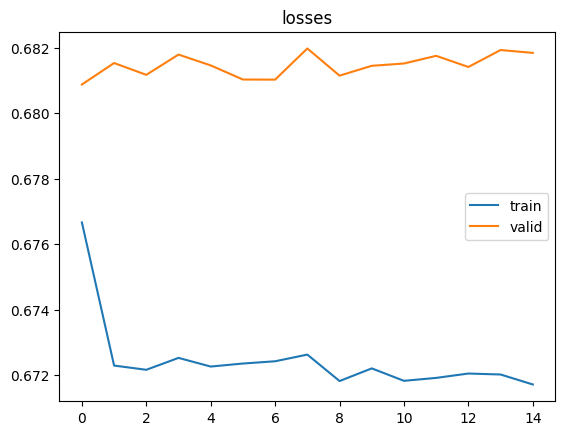

In [56]:
plt.title("losses")
plt.plot(losses["train_losses"], label="train")
plt.plot(losses["valid_losses"], label="valid")
plt.legend()
plt.show()

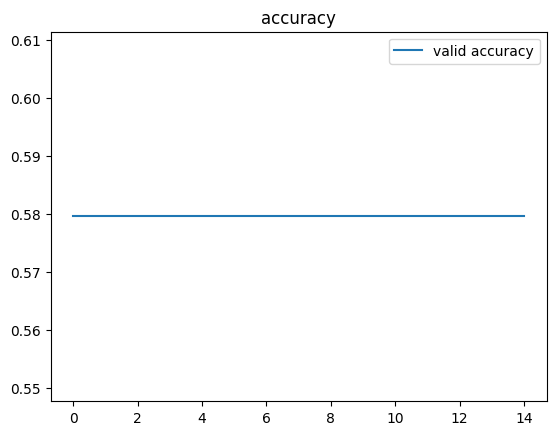

In [57]:
plt.title("accuracy")
plt.plot(losses["valid_acc"], label="valid accuracy")
plt.legend()
plt.show()

In [58]:
test_news_loss, test_news_acc = trainer.evaluate(test_news_dataloader)

In [59]:
print(f"Test loss {test_news_loss}, Test accuracy: {test_news_acc}")

Test loss 0.653164379298687, Test accuracy: 0.646484375


In [60]:
test_tweets_loss, test_tweets_acc = trainer.evaluate(test_tweets_dataloader)

In [61]:
print(f"Test loss {test_tweets_loss}, Test accuracy: {test_tweets_acc}")

Test loss 0.7142397135496139, Test accuracy: 0.5038896276595745
